**Importing the Librairies**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

**Loading Data**

In [2]:
base_dir=r"/content/drive/MyDrive/Desease classification"

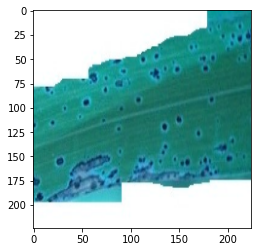

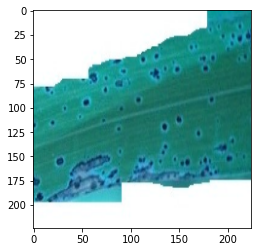

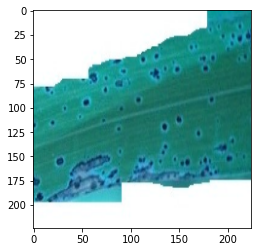

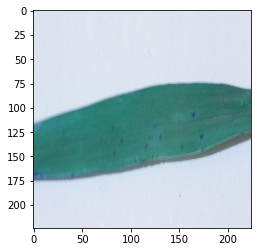

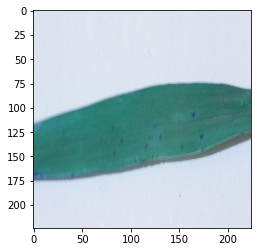

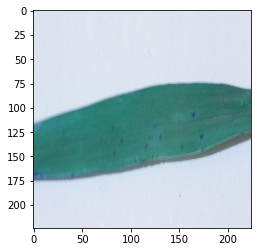

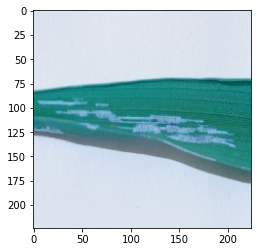

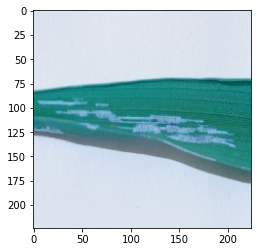

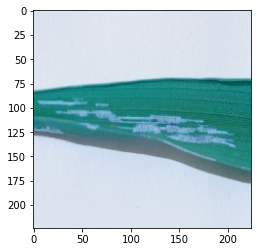

In [3]:
for folder in os.listdir(base_dir):
  sub_path= os.path.join(base_dir, folder)
  for img in os.listdir(sub_path):
    image_path=os.path.join(sub_path, img)
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
  for i in range(3):
    plt.imshow(img_arr)
    plt.show()

**Preparing Dataset**

In [4]:
IMAGE_SIZE=224
BATCH_SIZE = 8
EPOCHS = 30
#pre=processing
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

test_datagen=ImageDataGenerator(
     rescale=1./255,
     validation_split=0.2
)

train_datagen=train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

test_datagen=test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


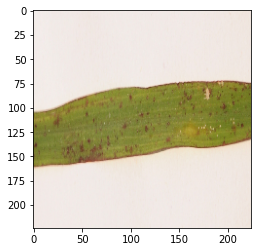

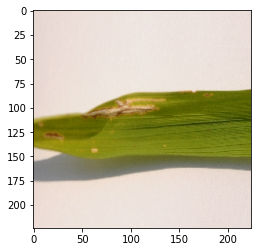

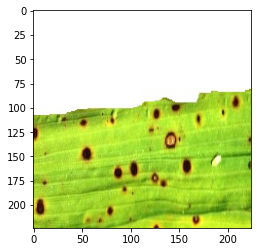

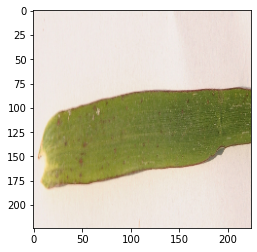

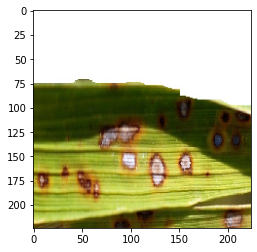

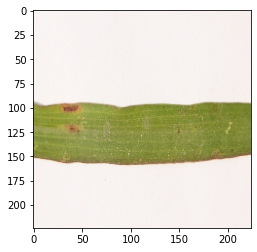

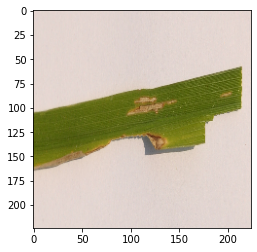

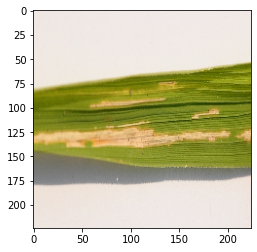

In [5]:
for img in test_datagen:
  images = img[0]
  labels = img[1]
  for i in range(len(labels)):
    plt.imshow(images[i])
    plt.show()
  break

In [6]:
# 
train_datagen.class_indices


{'Bacterial Leaf Blight': 0, 'Brown spot': 1, 'Leaf smut': 2}

**Convolution Neural Network Model**

In [7]:
cnn=Sequential()
cnn.add(Conv2D(filters= 64,kernel_size=3,activation='relu',input_shape=(224,224,3)))
cnn.add(Dropout(0.5))
cnn.add(MaxPool2D(2,2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(MaxPool2D(2,2))

cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPool2D(2,2))

cnn.add(Flatten())
cnn.add(Dense(16,activation='relu'))
cnn.add(Dense(3,activation='softmax'))

**Loss Function and Optimizer**

In [8]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',
                         mode='min',
                         verbose=1,
                         patience=7)
#Early stopping to avoid overfitting of model

**Train Model**

In [10]:

history = cnn.fit(train_datagen,
                  epochs= EPOCHS,
                  validation_data=test_datagen, 
                  callbacks = [early_stop]
                  )

Epoch 1/30
12/12 [==============================] - 11s 379ms/step - loss: 6.2877 - accuracy: 0.3333 - val_loss: 1.0914 - val_accuracy: 0.3333
Epoch 2/30
12/12 [==============================] - 4s 372ms/step - loss: 1.1998 - accuracy: 0.3542 - val_loss: 1.0889 - val_accuracy: 0.3333
Epoch 3/30
12/12 [==============================] - 4s 372ms/step - loss: 1.1357 - accuracy: 0.3021 - val_loss: 1.0991 - val_accuracy: 0.2917
Epoch 4/30
12/12 [==============================] - 4s 362ms/step - loss: 1.1159 - accuracy: 0.3333 - val_loss: 1.0985 - val_accuracy: 0.2083
Epoch 5/30
12/12 [==============================] - 4s 380ms/step - loss: 1.1065 - accuracy: 0.4583 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 6/30
12/12 [==============================] - 4s 370ms/step - loss: 1.0159 - accuracy: 0.5208 - val_loss: 1.0919 - val_accuracy: 0.3333
Epoch 7/30
12/12 [==============================] - 5s 397ms/step - loss: 0.9701 - accuracy: 0.5625 - val_loss: 0.9754 - val_accuracy: 0.7500
Epoch

**Check Performance**

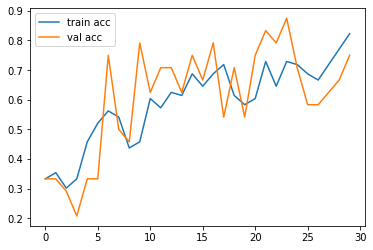

In [11]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

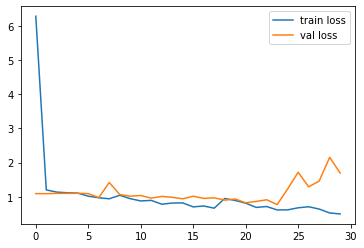

In [12]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

**Pre-trained Model VGG19**

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19

In [14]:

vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False) # include_top = False means the output layer of pre-trained model we don't consider because we will set the outpur layer.
#do not train the pre-trained layers of VGG-19, because those layers already trained
for layer in vgg.layers:
    layer.trainable = False    

In [15]:
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
vgg_model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [19]:

# fit the model
history = vgg_model.fit(
  train_datagen,
  validation_data=test_datagen,
  epochs=EPOCHS,
  callbacks=[early_stop],
  batch_size=8)

Epoch 1/30
12/12 [==============================] - 5s 416ms/step - loss: 0.1292 - accuracy: 0.9583 - val_loss: 0.7215 - val_accuracy: 0.7500
Epoch 2/30
12/12 [==============================] - 5s 406ms/step - loss: 0.0966 - accuracy: 0.9583 - val_loss: 0.7738 - val_accuracy: 0.7083
Epoch 3/30
12/12 [==============================] - 5s 409ms/step - loss: 0.0835 - accuracy: 0.9792 - val_loss: 0.8754 - val_accuracy: 0.7500
Epoch 4/30
12/12 [==============================] - 5s 399ms/step - loss: 0.0826 - accuracy: 0.9792 - val_loss: 0.9668 - val_accuracy: 0.5417
Epoch 5/30
12/12 [==============================] - 5s 398ms/step - loss: 0.0706 - accuracy: 0.9896 - val_loss: 0.9416 - val_accuracy: 0.5833
Epoch 6/30
12/12 [==============================] - 5s 404ms/step - loss: 0.0920 - accuracy: 0.9583 - val_loss: 1.0157 - val_accuracy: 0.5833
Epoch 7/30
12/12 [==============================] - 5s 398ms/step - loss: 0.1179 - accuracy: 0.9375 - val_loss: 0.9060 - val_accuracy: 0.7917
Epoch 

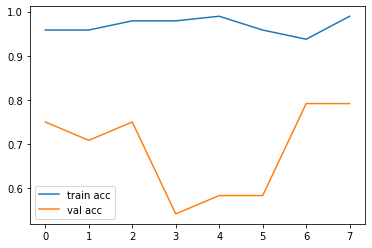

In [22]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

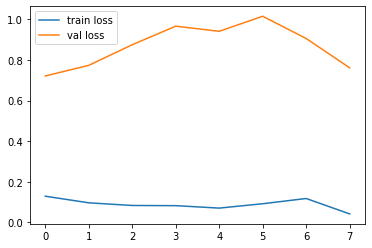

In [23]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

**Pre-trained model InceptionV3**

In [24]:

from tensorflow.keras.applications import InceptionV3

In [25]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (224, 224, 3),
                         include_top = False,
                         weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [26]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)
from tensorflow.keras.models import Model
inception_model = Model(inputs=base_model.input, outputs=prediction)

In [27]:
inception_model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [28]:
# fit the model
history = inception_model.fit(
  train_datagen,
  validation_data=test_datagen,
  epochs=EPOCHS,
  callbacks=[early_stop],
  batch_size=8)

Epoch 1/30
12/12 [==============================] - 10s 477ms/step - loss: 39.6860 - accuracy: 0.2812 - val_loss: 11.0229 - val_accuracy: 0.6667
Epoch 2/30
12/12 [==============================] - 5s 386ms/step - loss: 3.4022 - accuracy: 0.7917 - val_loss: 4.6573 - val_accuracy: 0.7083
Epoch 3/30
12/12 [==============================] - 5s 391ms/step - loss: 1.6689 - accuracy: 0.8229 - val_loss: 13.9241 - val_accuracy: 0.6250
Epoch 4/30
12/12 [==============================] - 5s 398ms/step - loss: 0.8260 - accuracy: 0.8750 - val_loss: 3.2082 - val_accuracy: 0.7500
Epoch 5/30
12/12 [==============================] - 5s 398ms/step - loss: 1.0078 - accuracy: 0.9271 - val_loss: 2.2943 - val_accuracy: 0.7917
Epoch 6/30
12/12 [==============================] - 5s 391ms/step - loss: 0.4931 - accuracy: 0.9375 - val_loss: 12.0093 - val_accuracy: 0.7083
Epoch 7/30
12/12 [==============================] - 5s 395ms/step - loss: 0.5621 - accuracy: 0.9583 - val_loss: 2.8433 - val_accuracy: 0.7083
E

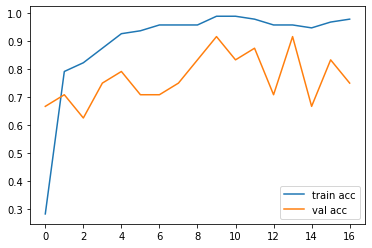

In [32]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

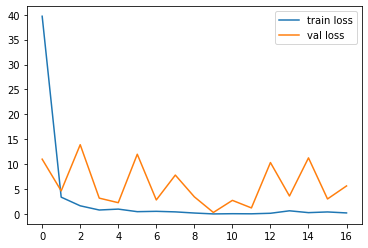

In [33]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

[[9.9238425e-01 7.6157916e-03 7.5160363e-17]]
0
Class is : Bacterial Leaf Blight


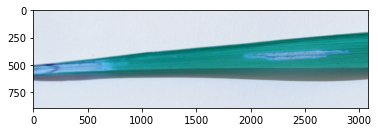

In [43]:
img_path = "/content/drive/MyDrive/Desease classification/Bacterial Leaf Blight/DSC_0373.JPG"
#img_path = "/content/drive/MyDrive/Desease classification/Brown spot/DSC_0108.jpg" 
#img_path = "/content/drive/MyDrive/Desease classification/Leaf smut/DSC_0503.jpg"

from tensorflow.keras.applications.imagenet_utils import preprocess_input
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))

from tensorflow.keras.preprocessing import image
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img = preprocess_input(img)
output = vgg_model.predict(img)
#output = inception_model.predict(img)
print(output)
x = np.argmax(output)
print(x)
if (x == 0):
  print("Class is : Bacterial Leaf Blight")
  plt.imshow(cv2.imread(img_path))
  plt.show()
elif (x == 1):
  print("Class is : Brown Spot")
  plt.imshow(cv2.imread(img_path))
  plt.show() 
else:
  print("Class is : Leaf Smut")  
  plt.imshow(cv2.imread(img_path))
  plt.show()
